In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
import seaborn as sns

In [2]:
df = pd.read_pickle('top500_data_nona.pkl')
print(df.head(10))
print(df.columns.tolist())

Price       Adj Close                                                      \
Ticker              A       AAL      AAPL        ABT      ACGL        ACN   
Date                                                                        
2010-01-04  20.122231  4.496876  6.461977  18.952156  7.994444  32.212460   
2010-01-05  19.903646  5.005957  6.473150  18.799036  7.967778  32.411537   
2010-01-06  19.832930  4.798555  6.370183  18.903446  7.933333  32.756092   
2010-01-07  19.807222  4.939964  6.358408  19.060040  7.886667  32.725471   
2010-01-08  19.800783  4.845692  6.400681  19.157484  7.871111  32.595306   
2010-01-11  19.813646  4.751418  6.344217  19.254921  7.846667  32.564678   
2010-01-12  19.575775  4.789126  6.272050  19.199244  7.868889  32.357944   
2010-01-13  19.730062  5.166223  6.360522  19.381519  7.911111  32.725471   
2010-01-14  20.025801  5.269926  6.323684  19.402557  7.900000  33.016426   
2010-01-15  19.562920  5.185078  6.218002  19.451632  7.885556  32.779068   

In [4]:
# Let us pick a company and daily Adjusted Closing price
#ticker = 'ULTA'
ticker = 'KO'
company = 'Coca Cola'
attr = 'Adj Close'

In [5]:
# Create a data extenion with daily adjusted close price for given stock
daily_close_data = df[[(attr, ticker)]].reset_index()
daily_close_data.columns = daily_close_data.columns.get_level_values(0)
daily_close_data.head()
daily_close = daily_close_data.set_index('Date') 
daily_close.head() 

Price,Adj Close
Date,
2010-01-04,18.351234
2010-01-05,18.129238
2010-01-06,18.122810
2010-01-07,18.077763
2010-01-08,17.743168


In [6]:
scale = MinMaxScaler(feature_range=(0,1))
# train test split the time series in the order
train_df = daily_close.iloc[:2534]
test_df = daily_close.iloc[2534:]
train_lstm= scale.fit_transform(train_df)
test_lstm = scale.fit_transform(test_df)

In [7]:
#train_lstm,test_lstm = train_test_split(daily_close_LSTM,train_size=0.7,shuffle=False)
print(train_lstm.shape)
print(test_lstm.shape)

(2534, 1)
(1087, 1)


In [8]:
X_train = []
y_train = []
n_timesteps = 100

for i in range(n_timesteps,2534):
    X_train.append(train_lstm[i-n_timesteps:i,0])
    y_train.append(train_lstm[i,0])

#print(X_train[0:2])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)
print(y_train.shape)

(2434, 100, 1)
(2434,)


In [9]:
model = Sequential()
model.add(Input(shape=(n_timesteps, 1)))
model.add(LSTM(units=100, activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, activation='relu',return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - loss: 0.0340
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 0.0013
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 0.0011
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 0.0011
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - loss: 0.0010
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - loss: 0.0010
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 9.6177e-04
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - loss: 9.3114e-04
Epoch 9/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - loss: 9.0132e-04
Epoch 10/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 0.0011
Epoch 11/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 9.2498e-04
Epoch 12/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - loss: 8.1522e-04
Epoch 13/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 0.0012
Epoch 14/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - loss: 0.0017
Epoch 15/20
77/77 ━━━━━

In [10]:
#prepare test data
X_test = []
y_test = []
n_timesteps = 100

for i in range(n_timesteps,1087):
    X_test.append(test_lstm[i-n_timesteps:i,0])
    y_test.append(test_lstm[i,0])

#print(X_train[0:2])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test= np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
X_test.shape

(987, 100, 1)

In [11]:
predictions = model.predict(X_test)
print(predictions.shape)
print(y_test.shape)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
(987, 1)
(987,)


In [12]:
mse = np.mean((predictions - y_test) ** 2)
print("Mean Squared Error:", mse)
pred_list = [item[0] for item in predictions]
#print(pred_list)
#print(y_test)

Mean Squared Error: 0.08083104540798532


In [13]:
daily_close_LSTM = np.concatenate([train_lstm, test_lstm])
plot_df = pd.DataFrame({'Date': daily_close.index, 'Adj Close': daily_close_LSTM.reshape(3621)})
plot_df.set_index('Date', inplace=True)

pred_ind = daily_close.index[2634:]
pred_df = pd.DataFrame({'Date': pred_ind, 'Adj Close': pred_list})
pred_df.set_index('Date', inplace=True)
#print(daily_close_LSTM.shape)

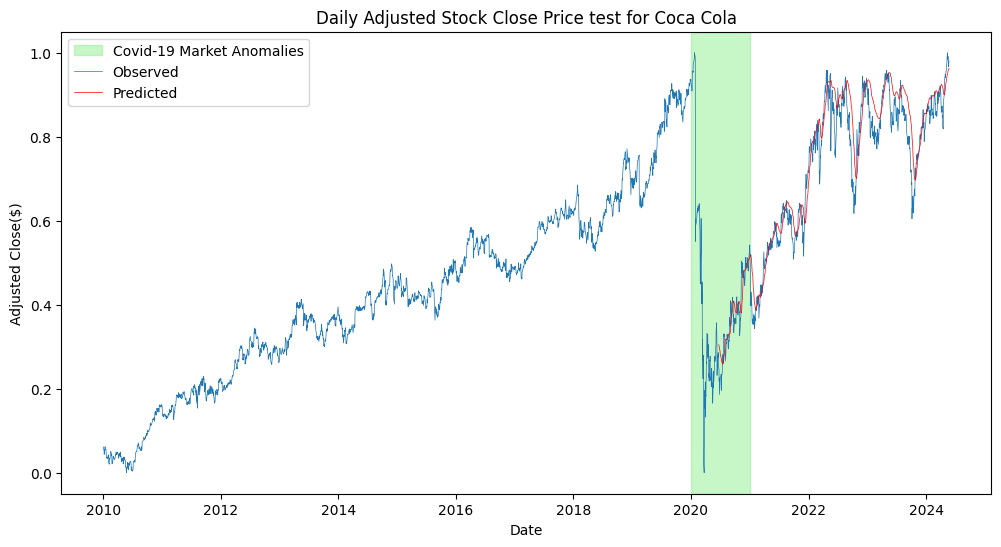

In [14]:
plt.figure(figsize=(12, 6)) 
line_o, = plt.plot(plot_df, linewidth=0.5, label='Observed') 
line_p, = plt.plot(pred_df, linewidth=0.5, label='Predicted',color='r')
plt.axvspan('2020','2021',color='#90EE90',alpha=.5)
plt.legend(handles=[mpatches.Patch(color='#90EE90',alpha=.5, label="Covid-19 Market Anomalies"),line_o,line_p])
plt.title("Daily Adjusted Stock Close Price test for "+company) 
plt.xlabel("Date") 
plt.ylabel("Adjusted Close($)")
#plt.legend() 
plt.show()

In [15]:
#predicting future data
daily_close_LSTM_r = daily_close_LSTM.reshape((-1))

def predict(num_prediction, model):
    prediction_list = daily_close_LSTM_r[-n_timesteps:]
    
    for _ in range(num_prediction):
        x = prediction_list[-n_timesteps:]
        x = x.reshape((1, n_timesteps, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[n_timesteps-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = daily_close.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 90
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)
print(forecast)
print(forecast_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

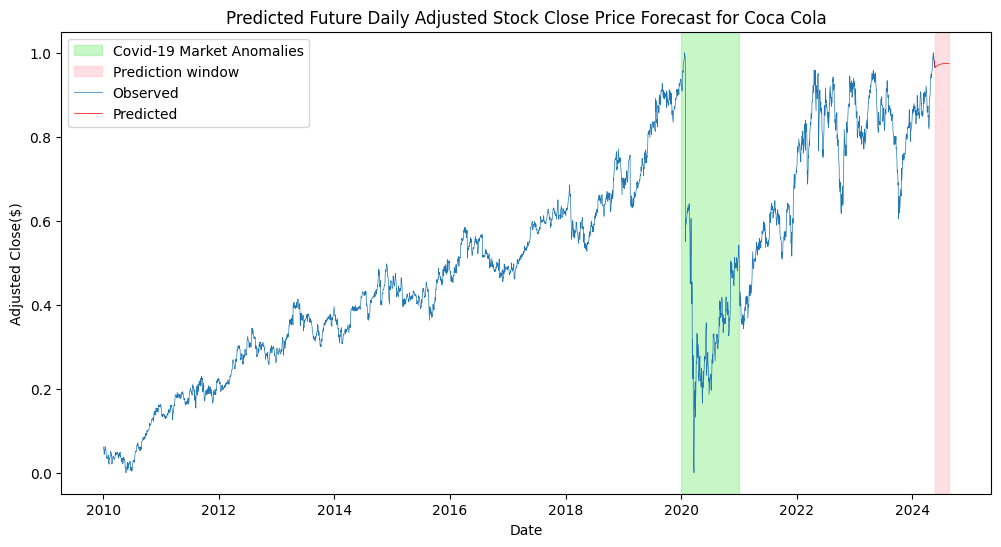

In [16]:
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Adj Close': forecast})
forecast_df.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6)) 
line_o, = plt.plot(plot_df, linewidth=0.5, label='Observed') 
line_p, = plt.plot(forecast_df, linewidth=0.5, label='Predicted',color='r')
plt.axvspan('2020','2021',color='#90EE90',alpha=.5)
plt.axvspan(forecast_df.index.values[0],forecast_df.index.values[-1],color='pink',alpha=.5)
plt.legend(handles=[mpatches.Patch(color='#90EE90',alpha=.5, label="Covid-19 Market Anomalies"),mpatches.Patch(color='pink',alpha=.5, label="Prediction window"),line_o,line_p])
plt.title("Predicted Future Daily Adjusted Stock Close Price Forecast for "+company) 
plt.xlabel("Date") 
plt.ylabel("Adjusted Close($)")
#plt.legend() 
plt.show()

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 100)            │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 100)            │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 605,105 (2.31 MB)

 Trainable params: 201,701 (787.89 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 403,404 (1.54 MB)